In [1]:
# pip install pynbody

In [2]:
# pip install Pylians

In [1]:
import numpy as np
import pickle
from tqdm import tqdm
import pynbody
import MAS_library as MASL
import matplotlib.pyplot as plt
import smoothing_library as SL
from numba import jit

In [2]:
#reading a snapshot

path="/vol/calvin/data/talokda/new_simulations/512_100_1/snapshot_033"
snap=pynbody.load(path)

In [3]:
head=snap.properties
head

{'omegaM0': 0.315,
 'omegaL0': 0.685,
 'boxsize': Unit("1.00e+02 Mpc a h**-1"),
 'a': 0.9999999999999996,
 'h': 0.674,
 'time': Unit("9.51e-03 s Mpc a**1/2 h**-1 km**-1")}

In [40]:
snap.loadable_keys()

['mass', 'pos', 'vel', 'iord']

In [41]:
ids = snap['iord']

In [6]:
# np.save("/vol/calvin/data/adave/Internship/Particle_ids.npy", ids)

In [42]:
pos = snap['pos']

In [43]:
pos.shape

(134217728, 3)

In [9]:
# np.save("/vol/calvin/data/adave/Internship/Particle_position.npy", pos)

In [10]:
vel = snap['vel']

In [11]:
vel.shape

(134217728, 3)

In [12]:
np.mean(snap['mass'])

SimArray(0.06512789, dtype=float32, '1.00e+10 Msol h**-1')

In [13]:
np.sum(snap['mass']) / pos.shape[0]

SimArray(0.06512789, '1.00e+10 Msol h**-1')

In [32]:
vel_mag = np.sqrt(np.sum(np.power(vel, 2), axis = 1))

In [33]:
vel_mag.shape

(134217728,)

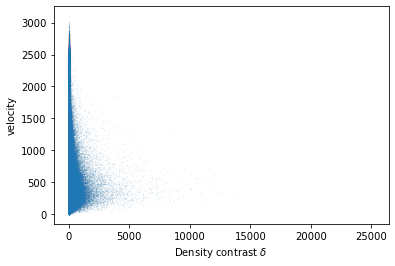

In [34]:
plt.scatter(rho_rs, vel_mag, s = 0.001)
plt.xlabel(r'Density contrast $\delta$')
plt.ylabel('velocity')
plt.show()

In [11]:
# np.save("/vol/calvin/data/adave/Internship/Velocity_field.npy", pec_vels)

In [12]:
# slice_index = 500

# # Extract the slice along the Z-axis
# slice_positions = pos[:100, :100, slice_index, :]
# print(slice_positions.shape)
# # Create a 2D scatter plot for the slice
# plt.scatter(slice_positions[:100, :100, 0], slice_positions[:100, :100, 1], s=1, c='b', marker='o')

# # Set labels
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')

# plt.title(f'Projection of Slice at Z={slice_index}')
# plt.show()


In [44]:
grid_size=512

box_size=100.0

def compute_density_field(snapshot, mas='CIC', verbose=True):
    """
    Compute the density field from a cosmological simulation snapshot.

    Parameters:
    - snapshot: pynbody.snapshot object
      The cosmological simulation snapshot.
    - grid_size: int, optional (default=512)
      The size of the 3D grid for the density field.
    - box_size: float, optional (default=100.0)
      The size of the simulation box in Mpc/h.
    - mas: str, optional (default='CIC')
      The mass-assignment scheme. Options: 'NGP', 'CIC', 'TSC', 'PCS', 'gaussian'.
    - verbose: bool, optional (default=True)
      Print information on progress.

    Returns:
    - delta: numpy.ndarray
      The computed density field representing density contrast in each voxel.
    """

    # Number of particles (Np) in the snapshot is 512**3

    # Particle positions in 3D
    pos = snapshot["pos"]

    # Initialize 3D density field
    delta = np.zeros((grid_size, grid_size, grid_size), dtype=np.float32)

    # Construct 3D density field using mass-assignment scheme
    MASL.MA(pos, delta, box_size, mas, verbose=verbose)

    # Compute overdensity and density contrast
    delta /= np.mean(delta, dtype=np.float64)
    delta -= 1.0

    return delta

In [45]:
rho = compute_density_field(snap)


Using CIC mass assignment scheme
Time taken = 2.052 seconds



In [21]:
rho.shape

(512, 512, 512)

In [20]:
rho_rs = rho.reshape(512*512*512)

In [16]:
# np.save("/vol/calvin/data/adave/Internship/Density_field.npy", rho)

In [17]:
mass = snap['mass']

def calculate_smoothing_scale(density_field):
    # Step 1: Compute mean density
    mean_density = mass[0] * (grid_size)**3 / (box_size)**3 # Mass of one particle times number of particles / size of the box^3

    # Step 2: Define mass resolution (M_s)
    voxel_volume = (box_size / grid_size) ** 3
    M_s = mean_density * voxel_volume

    # Step 3: Calculate smoothing scale (R_s)
    R_s = (1 / np.sqrt(2 * np.pi)) * (M_s / mean_density) ** (1 / 3)

    return R_s

In [18]:
# Theoretical smoothing scale
smoothing_scale = calculate_smoothing_scale(rho)

print("Smoothing Scale (Rs):", smoothing_scale, r'h-1 Mpc')

Smoothing Scale (Rs): 0.07791841414090482 h-1 Mpc


In [46]:
from scipy.ndimage import gaussian_filter

def smooth_field(field, smoothing_scale):
#     Filter  = 'Gaussian'
#     threads = 4

#     # compute FFT of the filter
#     W_k = SL.FT_filter(box_size, smoothing_scale, grid_size, Filter, threads)

#     # smooth the field
#     smoothed_density = SL.field_smoothing(density_field, W_k, threads)
    
    # Calculate the standard deviation of the Gaussian kernel
    sigma = smoothing_scale

    # Calculate the pixel scale (size of each voxel in the simulation)
    pixel_scale = box_size / grid_size

    # Calculate the standard deviation in pixels
    sigma_pixels = sigma / pixel_scale

    # Apply Gaussian filter to the density field
    smoothed_field = gaussian_filter(field, sigma=sigma_pixels, mode='wrap', cval=0.0)

    return smoothed_field

### Velocity smoothing

In [21]:
vs = smooth_field(vel, 1)

In [22]:
voxel_keys = np.load("/vol/calvin/data/adave/Internship/Voxel_keys.npy")

In [23]:
# Load the dictionary from the pickle file
with open('voxel_info.pkl', 'rb') as pickle_file:
    voxel_info = pickle.load(pickle_file)

In [24]:
voxel_vel = np.zeros((512, 512, 512, 3))
voxel_pos = np.zeros((512, 512, 512, 3))

for keys in tqdm(voxel_keys):
    i, j, k = keys
    
    all_ind = voxel_info[i, j, k]
    mean_vox_vel = np.mean(vs[all_ind], axis = 0)
    mean_vox_pos = np.mean(pos[all_ind], axis = 0)
    
    voxel_vel[i, j, k] = mean_vox_vel
    voxel_pos[i, j, k] = mean_vox_pos

voxel_vel[voxel_vel == 0] = np.nan
voxel_pos[voxel_pos == 0] = np.nan

100%|██████████| 26564815/26564815 [20:01<00:00, 22114.46it/s]


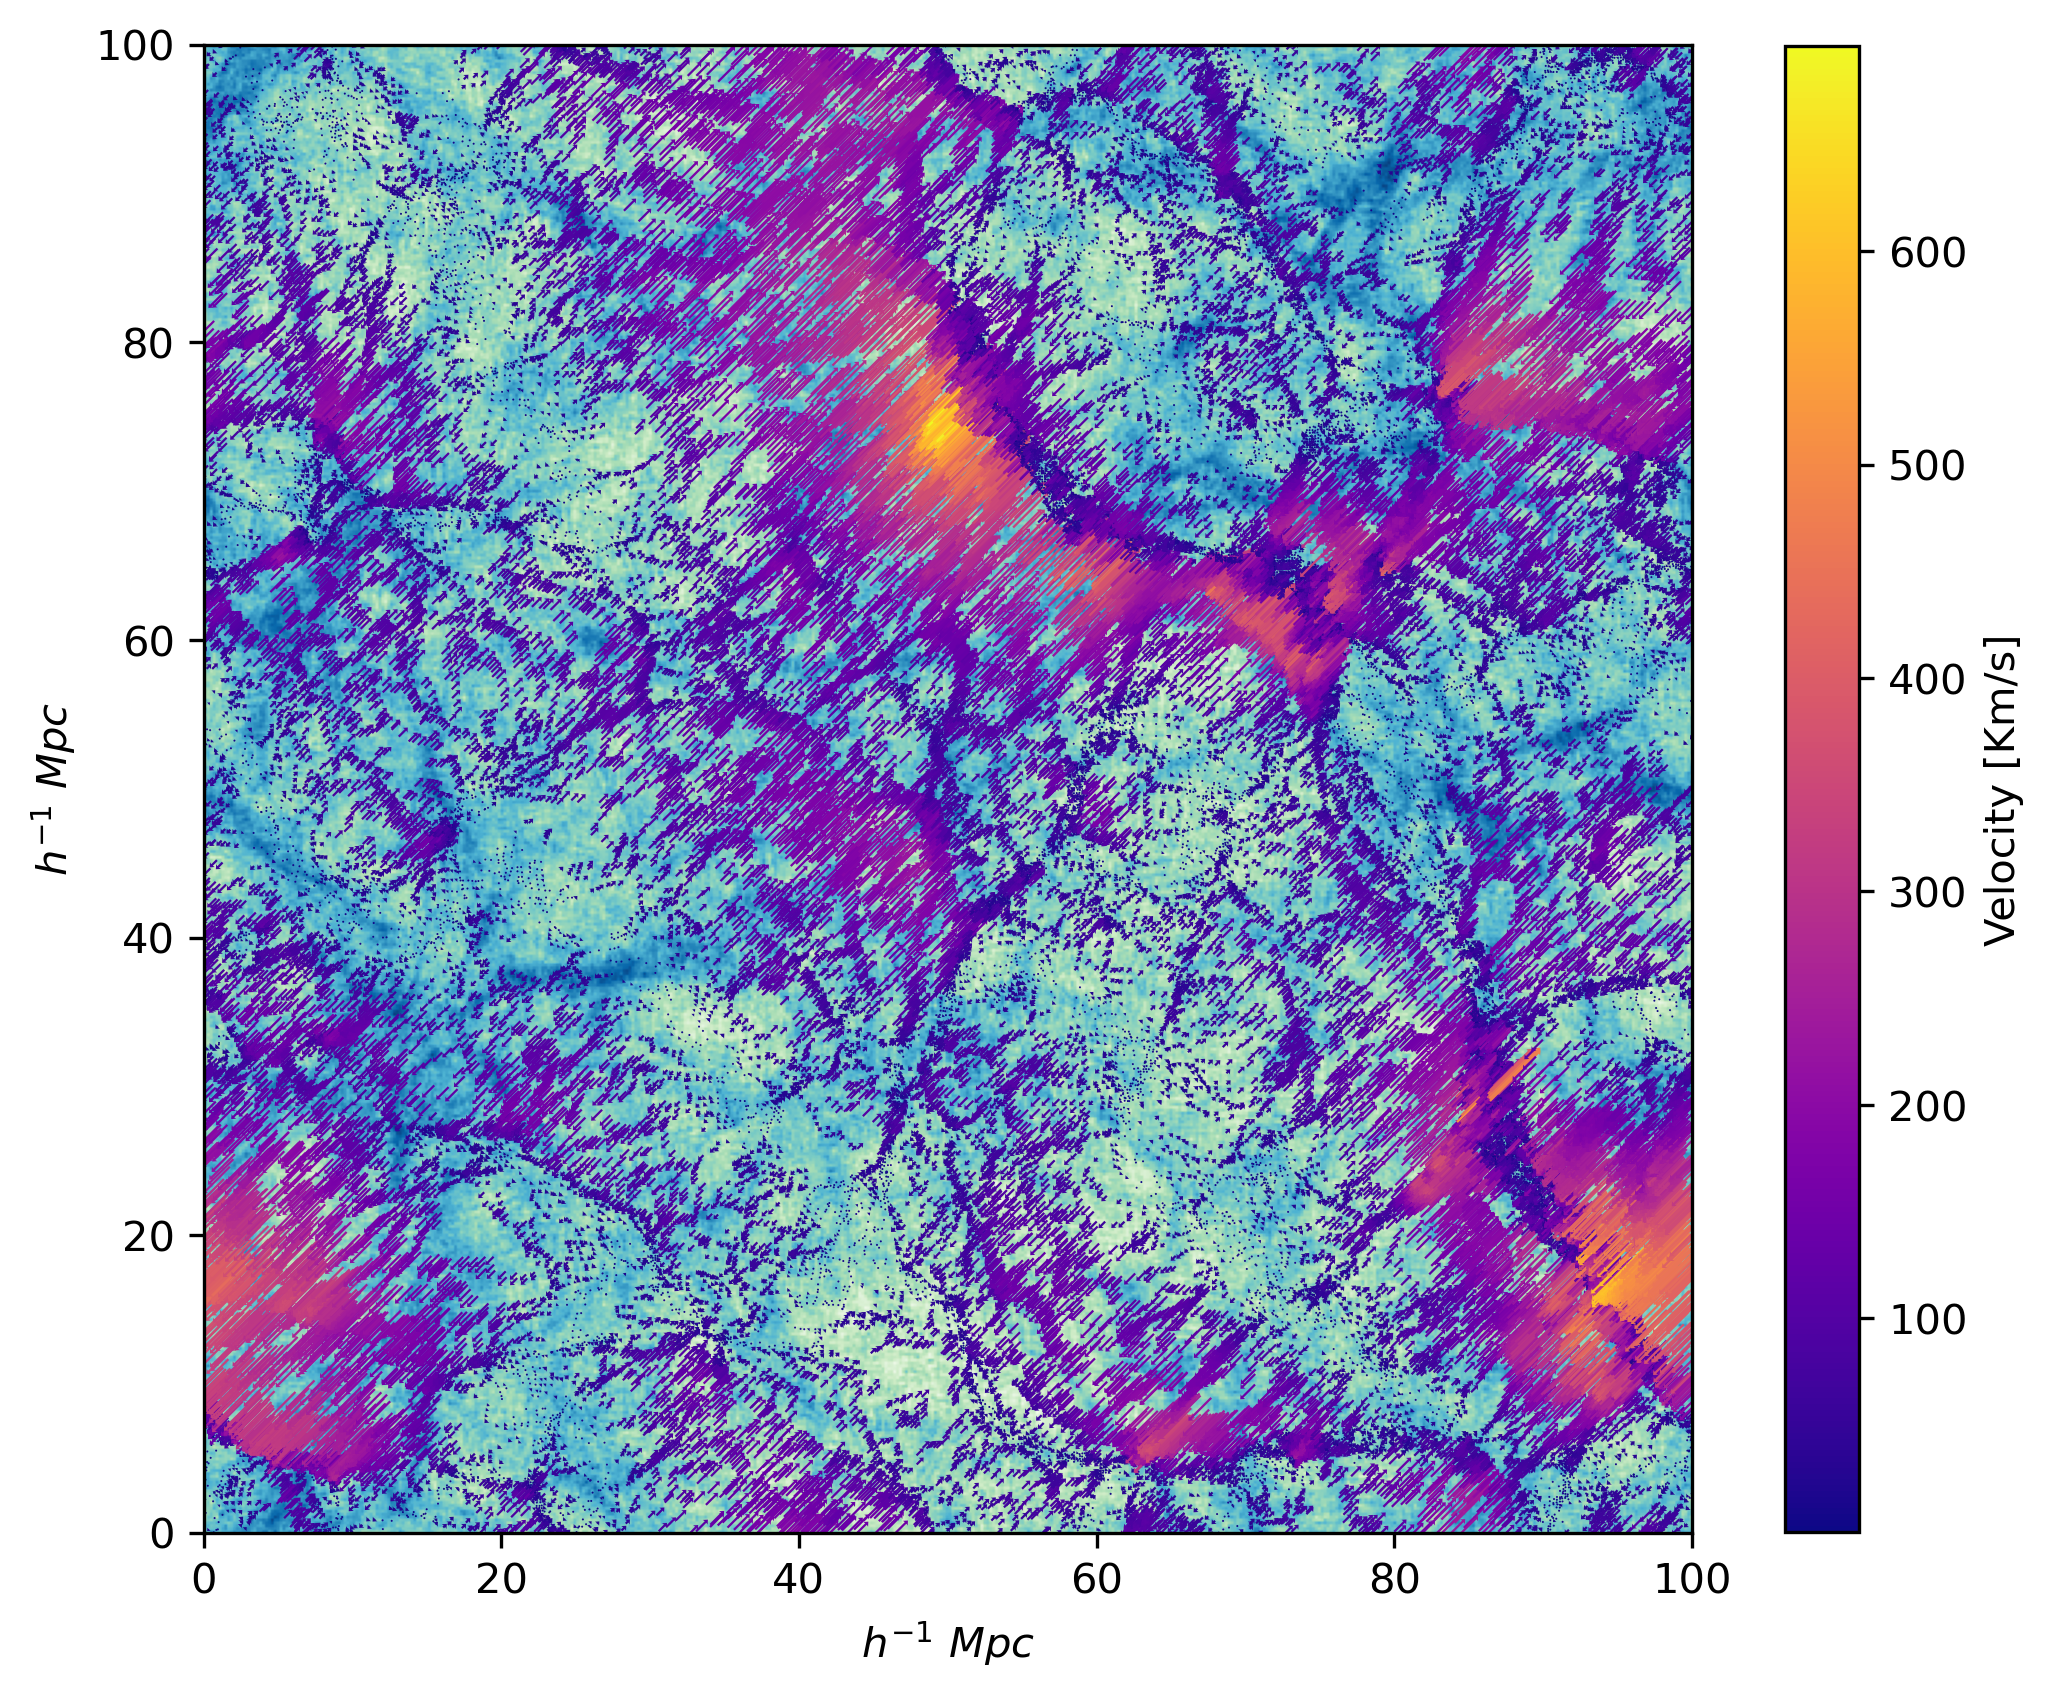

In [25]:
# voxel_pos = pos.reshape(512, 512, 512, 3)
# voxel_vel = vs.reshape(512, 512, 512, 3)

eps = 1e-15  # so that log doesn't get a value 0
N = 0

headlength = 1.7
headaxislength = 1.5
width = 0.0015
headwidth = 3
scale=10000

slice_index = 256
    
init = None
final = None
    

vels = np.hypot(voxel_vel[:, :, slice_index, 0], voxel_vel[:, :, slice_index, 1])

plt.figure(figsize = (8, 8), dpi = 300)

delplot1 = np.log10(rho + 1 + eps)
slic1 = np.mean((delplot1[init:final, init:final, N:slice_index + N]), axis=2)

plt.imshow(slic1, cmap='GnBu', extent = [0, 100, 0, 100], origin='lower')
plt.quiver(voxel_pos[:, :, slice_index, 0], voxel_pos[:, :, slice_index, 1], 
           voxel_vel[:, :, slice_index, 0], voxel_vel[:, :, slice_index, 1], vels,
           headlength = headlength, width = width, headaxislength = headaxislength, scale=scale, headwidth = headwidth,
           pivot = 'mid', angles = 'uv', units = 'height',
           color = 'black', alpha = 1, cmap = plt.cm.plasma)

plt.colorbar(label = 'Velocity [Km/s]', shrink = 0.82)
plt.xlabel('$h^{-1}~Mpc$')
plt.ylabel('$h^{-1}~Mpc$')

plt.show()

### Density smoothing

In [47]:
smoothed_rho_007 = smooth_field(rho, 0.078)
np.save("/vol/calvin/data/adave/Internship/SmoothDensityField007.npy", smoothed_rho_007)

In [16]:
smoothed_rho_054 = smooth_field(rho, 0.54)
np.save("/vol/calvin/data/adave/Internship/SmoothDensityField054.npy", smoothed_rho_054)

In [17]:
smoothed_rho_076 = smooth_field(rho, 0.76)
np.save("/vol/calvin/data/adave/Internship/SmoothDensityField076.npy", smoothed_rho_076)

In [18]:
smoothed_rho_116 = smooth_field(rho, 1.167)
np.save("/vol/calvin/data/adave/Internship/SmoothDensityField116.npy", smoothed_rho_116)

In [19]:
smoothed_rho_13 = smooth_field(rho, 1.3)
np.save("/vol/calvin/data/adave/Internship/SmoothDensityField13.npy", smoothed_rho_13)

In [20]:
smoothed_rho_21 = smooth_field(rho, 2.1)
np.save("/vol/calvin/data/adave/Internship/SmoothDensityField21.npy", smoothed_rho_21)

In [21]:
smoothed_rho_35 = smooth_field(rho, 3.5)
np.save("/vol/calvin/data/adave/Internship/SmoothDensityField35.npy", smoothed_rho_35)

In [22]:
smoothed_rho_41 = smooth_field(rho, 4.1)
np.save("/vol/calvin/data/adave/Internship/SmoothDensityField41.npy", smoothed_rho_41)

In [23]:
smoothed_rho_67 = smooth_field(rho, 6.7)
np.save("/vol/calvin/data/adave/Internship/SmoothDensityField67.npy", smoothed_rho_67)

In [24]:
smoothed_rho_85 = smooth_field(rho, 8.5)
np.save("/vol/calvin/data/adave/Internship/SmoothDensityField85.npy", smoothed_rho_85)

In [25]:
smoothed_rho_101 = smooth_field(rho, 10.1)
np.save("/vol/calvin/data/adave/Internship/SmoothDensityField101.npy", smoothed_rho_101)

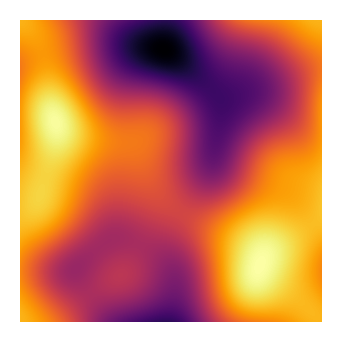

In [37]:
eps=1e-15 # so that log doesn't get a value 0
N=1
halfbox=256

# Plot for zero smoothening density field
plt.figure(figsize = (2,2), dpi = 200)
delplot1=np.log10(smoothed_rho_85+1+eps)
slic1=np.mean(delplot1[:, :, N:halfbox+N],axis=2)

plt.imshow(slic1, cmap = 'inferno')
plt.axis('off')
plt.show()

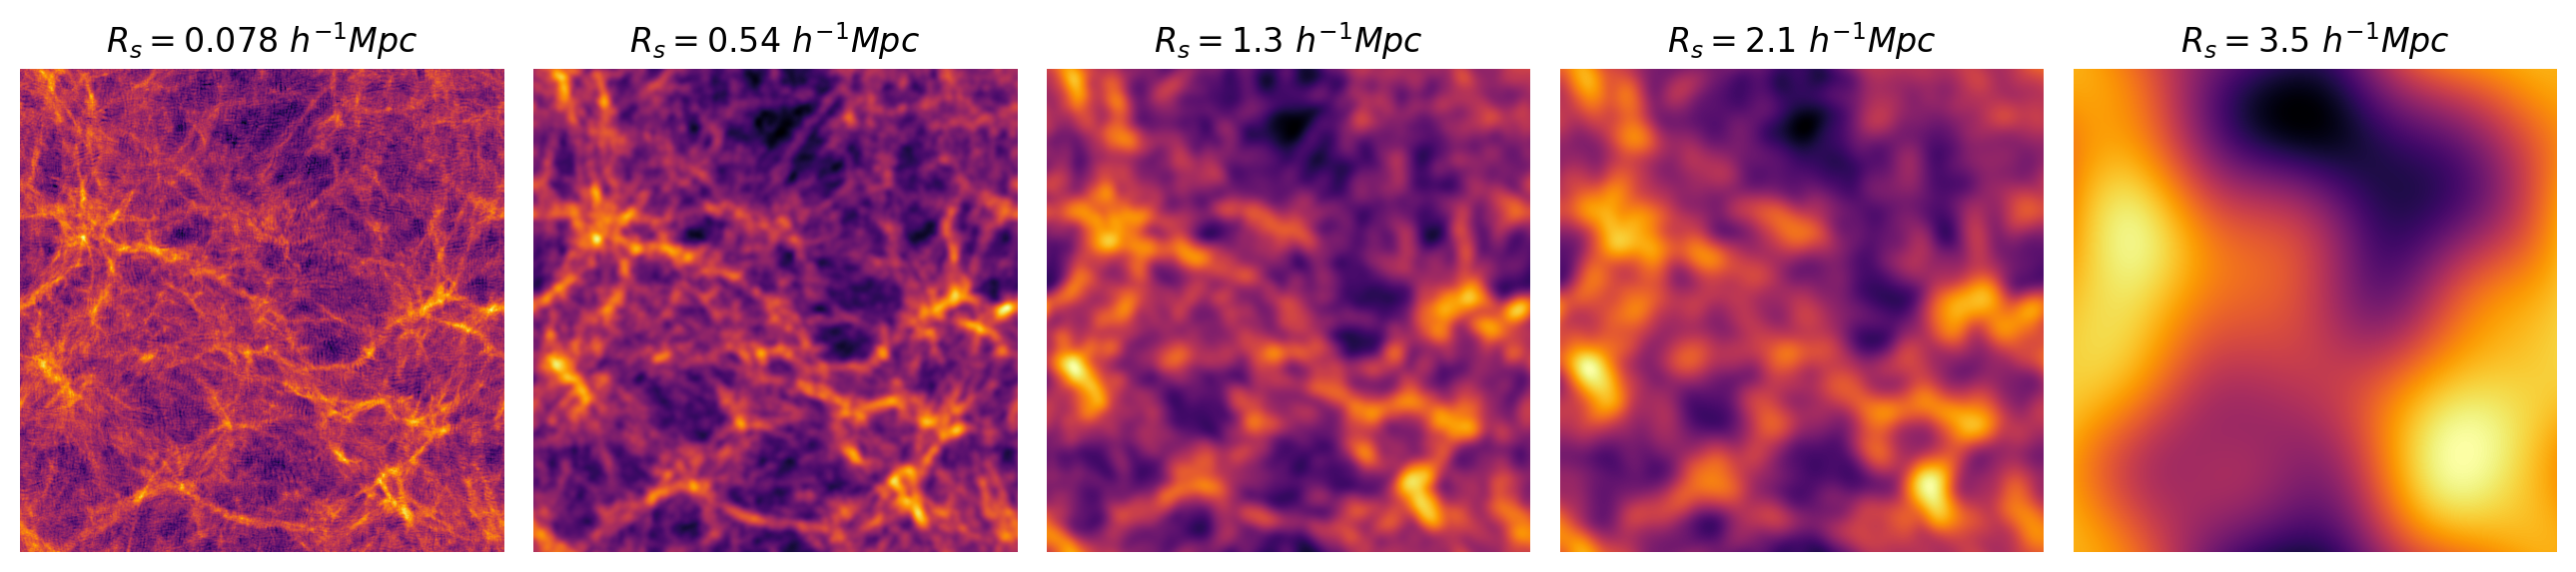

In [29]:
eps=1e-15 # so that log doesn't get a value 0
N=10
halfbox=256

delplot1=np.log10(smoothed_rho_007+1+eps)
delplot2=np.log10(smoothed_rho_054+1+eps)
delplot3=np.log10(smoothed_rho_13+1+eps)
delplot4=np.log10(smoothed_rho_21+1+eps)
delplot5=np.log10(smoothed_rho_101+1+eps)

slic1=np.mean(delplot1[:,:,N:halfbox+N],axis=2)
slic2=np.mean(delplot2[:,:,N:halfbox+N],axis=2)
slic3=np.mean(delplot3[:,:,N:halfbox+N],axis=2)
slic4=np.mean(delplot4[:,:,N:halfbox+N],axis=2)
slic5=np.mean(delplot5[:,:,N:halfbox+N],axis=2)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (13, 16), dpi = 200)

ax1.imshow(slic1, cmap = 'inferno')
ax1.set_title(r'$R_s = 0.078~h^{-1} Mpc$')
ax1.axis('off')

ax2.imshow(slic2, cmap = 'inferno')
ax2.set_title(r'$R_s = 0.54~h^{-1} Mpc$')
ax2.axis('off')

ax3.imshow(slic3, cmap = 'inferno')
ax3.set_title(r'$R_s = 1.3~h^{-1} Mpc$')
ax3.axis('off')

ax4.imshow(slic4, cmap = 'inferno')
ax4.set_title(r'$R_s = 2.1~h^{-1} Mpc$')
ax4.axis('off')

ax5.imshow(slic5, cmap = 'inferno')
ax5.set_title(r'$R_s = 3.5~h^{-1} Mpc$')
ax5.axis('off')

fig.tight_layout()
plt.show()

In [48]:
#Generating the Deformation or Tidal Shear tensor

def calculate_tidal_tensor(density_field):
    
    # Fast Fourier transform of density field
    density_field_fft = np.fft.fftn(density_field)

    shape = density_field.shape[0]

    #generating the k-space
    kx_modes = np.fft.fftfreq(shape)
    ky_modes = np.fft.fftfreq(shape)
    kz_modes = np.fft.fftfreq(shape)

    kx, ky,kz= np.meshgrid(kx_modes, ky_modes,kz_modes,indexing="ij")

    # Different permutations
    kx2=np.multiply(kx,kx)
    ky2=np.multiply(ky,ky)
    kz2=np.multiply(kz,kz)
    kxy=np.multiply(kx,ky)
    kxz=np.multiply(kx,kz)
    kyz=np.multiply(ky,kz)

    # Calculate k^2
    k_sq = kx2+ky2+kz2

    # Gravitational potential in k-space
    potential_k=-np.divide(density_field_fft, k_sq, where=k_sq != 0)
    
    # potential=np.fft.ifft(potential_k)

    # Calculate the tidal tensor components in k-space
    tidal_tensor = np.zeros((3,3)+density_field.shape, dtype=np.complex128)

    tk00=-potential_k*kx2
    tk01=-potential_k*kxy
    tk02=-potential_k*kxz
    tk11=-potential_k*ky2
    tk12=-potential_k*kyz
    tk22=-potential_k*kz2
    
    
    #Inverse transforming each component back
    tt00=np.fft.ifftn(tk00)
    tt01=np.fft.ifftn(tk01)
    tt02=np.fft.ifftn(tk02)
    tt12=np.fft.ifftn(tk12)
    tt11=np.fft.ifftn(tk11)
    tt22=np.fft.ifftn(tk22)
    
    # Assembling the tensor field (assigning the values to symmetric counterparts)
    tidal_tensor[0,0,...]=tt00
    tidal_tensor[1,0,...]=tt01
    tidal_tensor[0,1,...]=tt01
    tidal_tensor[1,1,...]=tt11
    tidal_tensor[0,2,...]=tt02
    tidal_tensor[2,0,...]=tt02
    tidal_tensor[2,2,...]=tt22
    tidal_tensor[1,2,...]=tt12
    tidal_tensor[2,1,...]=tt12

    tidal_tensor=tidal_tensor.real
    
    return tidal_tensor#, potential

# tidal_tensor has shape (3,3,512,512,512) for a 512^3 box
# It gives out the tidal tensor for each voxel in the simulation box

In [49]:
import time

s1 = time.perf_counter()
tid = calculate_tidal_tensor(smoothed_rho_007)
s2 = time.perf_counter()

print(s2 - s1)

50.31225496158004


In [39]:
import os

os.cpu_count()

256

In [54]:
from multiprocessing import Pool

def calculate_tidal_tensor_parallel(density_field_chunk, shape, calculate_potential=False):
    """
    Calculates the tidal tensor for a chunk of the density field.

    Parameters:
    - density_field_chunk: numpy.ndarray
      A chunk of the density field.
    - shape: tuple
      Shape of the entire density field.
    - calculate_potential: bool, optional (default=False)
      Calculate the potential field.

    Returns:
    - tidal_tensor_chunk: numpy.ndarray
      Tidal tensor chunk for the corresponding density field chunk.
    - potential_k_chunk (optional): numpy.ndarray
      Potential field chunk (if calculate_potential is True).
    """

    # Perform calculations on the chunk of density field_fft
    density_field_fft_chunk = np.fft.fftn(density_field_chunk)
    kx_modes = np.fft.fftfreq(shape[0])
    ky_modes = np.fft.fftfreq(shape[1])
    kz_modes = np.fft.fftfreq(shape[2])
    kx, ky, kz = np.meshgrid(kx_modes, ky_modes, kz_modes, indexing="ij")

  ## Different permutations
    kx2=np.multiply(kx,kx)
    ky2=np.multiply(ky,ky)
    kz2=np.multiply(kz,kz)
    kxy=np.multiply(kx,ky)
    kxz=np.multiply(kx,kz)
    kyz=np.multiply(ky,kz)

    # Calculate k^2
    k_sq = kx2+ky2+kz2

    # Gravitational potential in k-space
    potential_k=-np.divide(density_field_fft_chunk, k_sq, where=k_sq != 0)
    
    # potential_k_chunk=np.fft.ifft(potential_k)

    # Calculate the tidal tensor components in k-space
    tidal_tensor_chunk = np.zeros((3,3)+density_field_fft_chunk.shape, dtype=np.complex128)

    tk00=-potential_k*kx2
    tk01=-potential_k*kxy
    tk02=-potential_k*kxz
    tk11=-potential_k*ky2
    tk12=-potential_k*kyz
    tk22=-potential_k*kz2
    
    
    #Inverse transforming each component back
    tt00=np.fft.ifftn(tk00)
    tt01=np.fft.ifftn(tk01)
    tt02=np.fft.ifftn(tk02)
    tt12=np.fft.ifftn(tk12)
    tt11=np.fft.ifftn(tk11)
    tt22=np.fft.ifftn(tk22)
    
    # Assembling the tensor field (assigning the values to symmetric counterparts)
    tidal_tensor_chunk[0,0,...]=tt00
    tidal_tensor_chunk[1,0,...]=tt01
    tidal_tensor_chunk[0,1,...]=tt01
    tidal_tensor_chunk[1,1,...]=tt11
    tidal_tensor_chunk[0,2,...]=tt02
    tidal_tensor_chunk[2,0,...]=tt02
    tidal_tensor_chunk[2,2,...]=tt22
    tidal_tensor_chunk[1,2,...]=tt12
    tidal_tensor_chunk[2,1,...]=tt12

    tidal_tensor_chunk=tidal_tensor_chunk.real

    return tidal_tensor_chunk, potential_k_chunk if calculate_potential else None

def calculate_tidal_tensor(density_field, calculate_potential=False):
    """
    Calculate the tidal tensor from the given density field using multiprocessing.

    Parameters:
    - density_field: numpy.ndarray
    The density field.
    - calculate_potential: bool, optional (default=False)
    Calculate the potential field.

    Returns:
    - tidal_tensor: numpy.ndarray
    Tidal tensor (3x3 matrix) for each voxel in the simulation box.
    """

    # Determine the number of CPU cores
    num_cores = os.cpu_count()

    # Split the density field into chunks
    chunk_size = (density_field.shape[0] // num_cores, density_field.shape[1], density_field.shape[2])
    chunks = np.array_split(density_field, num_cores, axis=0)

    # Use a Pool of workers to process chunks in parallel
    with Pool(processes=num_cores) as pool:
        results = pool.starmap(calculate_tidal_tensor_parallel, 
                               zip(chunks, [density_field.shape] * num_cores, 
                                   [calculate_potential] * num_cores))

    # Combine the results from each chunk
    tidal_tensor_chunks, potential_k_chunks = zip(*results)
    tidal_tensor = np.concatenate(tidal_tensor_chunks, axis=0)

    if calculate_potential:
        potential_k = np.concatenate(potential_k_chunks, axis=0)
        return tidal_tensor, potential_k
    else:
        return tidal_tensor


In [55]:
s1 = time.perf_counter()
tid = calculate_tidal_tensor(smoothed_rho_007)
s2 = time.perf_counter()

print(s2 - s1)

KeyboardInterrupt: 

In [35]:
tid.shape

(3, 3, 512, 512, 512)

In [36]:
tidal_shear = tid.transpose(2, 3, 4, 0, 1)

In [37]:
np.save("/vol/calvin/data/adave/Internship/tidal_shear076.npy", tidal_shear)

Do the below steps to calculate traceless tidal shear

In [ ]:
#flattening tid into a list of matrices (512^3=134217728)

tid=tid.reshape(3, 3, grid_size, grid_size, grid_size)
tid=tid.transpose(2, 3, 4, 0, 1) #turning in into shape (134217728,3,3) because that will make things easier

In [1]:
#tidal shear is the traceless part of the deformation/full tidal tensor

def make_traceless(matrix):
    traceless_matrix = matrix - (np.trace(matrix) / 3) * np.identity(3)
    return traceless_matrix

In [ ]:
#"traceless" will be a list of 3x3 matrices, with length 512^3

traceless=[]
for i in tqdm(range(len(tid))):
    traceless.append(make_traceless(tid[i]))

In [ ]:
tidal_shear=np.array(traceless).reshape(grid_size,grid_size,grid_size,3,3)

In [ ]:
np.save("/vol/calvin/data/adave/Internship/Traceless_tidal_shear.npy",tidal_shear)

In [ ]:
# df_smoothed = [smoothed_rho_007, smoothed_rho_13, smoothed_rho_21, smoothed_rho_35]

# tidal_shear007 = np.zeros((512, 512, 512, 3, 3))
# tidal_shear13 = np.zeros((512, 512, 512, 3, 3))
# tidal_shear21 = np.zeros((512, 512, 512, 3, 3))
# tidal_shear35 = np.zeros((512, 512, 512, 3, 3))

# tidal_shears = [tidal_shear007, tidal_shear13, tidal_shear21, tidal_shear35]

# for i in tqdm(range(len(df_smoothed))):
    
#     tid = calculate_tidal_tensor(df_smoothed[i])
    
#     tid=tid.reshape(3,3,134217728)
#     tid=tid.transpose(2,0,1)
    
#     traceless=[]
#     for j in tqdm(range(len(tid))):
#         traceless.append(make_traceless(tid[j]))
        
#     tidal_shear = np.array(traceless).reshape(512,512,512,3,3)
    
#     tidal_shears[i] = tidal_shear
    